What we want to do:
	
	1. Set up a network with a bunch of nodes and edges between them
	2. The edges are connected to nodes in a power law distribution
	3. Each node has a particular "processing" capacity, distributed in a normal distribution
	4. Each node can also create information within its "processing" capacity; the creation ability is distributed in a normal distribution
	5. The "information" is created by a node in response to a) function of how much information has come into the node, b) the free "processing" capacity of that node
		a. Processing capacity reduces as more information comes into the node, in a linear fashion
		b. As each piece of information reaches another node, it gets read & processed, which takes "effort" until processing is done. Processing here mostly either (in increasing order of effort) accepts the information or changes it slightly or creates a variant information* which is similar or different according to a normal distribution
	6. Once created, this information propagates through the network like a cascade/ contagion

    alpha  min_degree  total_info
0       2           1  435.287280
1       2           1  528.366636
2       2           3  491.586744
3       2           3  406.529656
4       2           6  532.855640
5       2           6  591.460936
6       2           9  594.895535
7       2           9  666.405353
8       3           1  480.095814
9       3           1  384.303784
10      3           3  658.104570
11      3           3  281.282132
12      3           6  512.581211
13      3           6  414.750425
14      3           9  345.373521
15      3           9  416.868254
16      4           1  505.031106
17      4           1  470.021055
18      4           3  541.200722
19      4           3  221.142888
20      4           6  658.279572
21      4           6  599.266118
22      4           9  309.968016
23      4           9  652.670982
24      5           1  528.927350
25      5           1  462.931662
26      5           3  567.531916
27      5           3  568.011371
28      5     

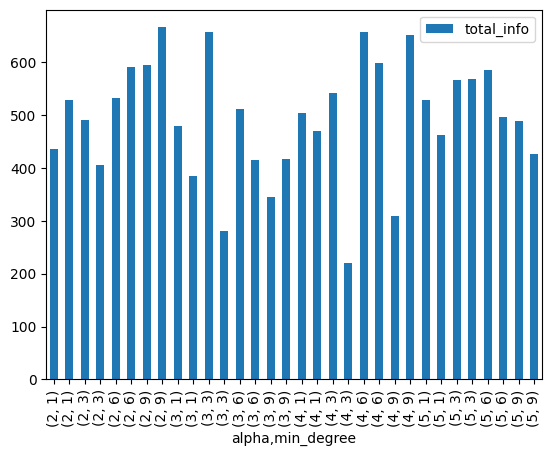

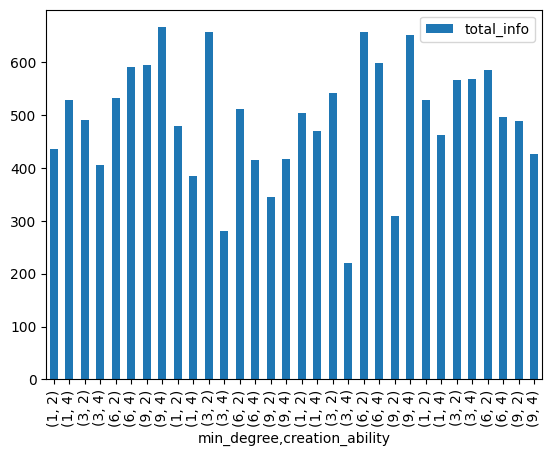

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import math

def create_information(incoming_info, processing_capacity, creation_ability):
    return max(min(incoming_info, processing_capacity), 0) * creation_ability

def process_information(new_info, processing_capacity):
    return max(min(new_info, processing_capacity), 0)

def run_simulation(num_nodes, min_degree, max_degree, alpha, processing_capacity_loc, processing_capacity_scale, creation_ability_loc, creation_ability_scale):
    # Generate power law degree sequence
    degrees = np.random.power(alpha, num_nodes) * (max_degree - min_degree) + min_degree
    # Adjust the degrees to be integers
    degrees = np.floor(min_degree + (max_degree - min_degree) * degrees / np.max(degrees)).astype(int)

    # Ensure that the sum of the degrees is even
    if sum(degrees) % 2 != 0:
        degrees[np.argmax(degrees)] += 1

    # Create power law degree sequence
    G = nx.powerlaw_cluster_graph(num_nodes, m=min_degree, p=0.05, seed=42) # Add power-law clustering

    # Assign processing capacity and creation ability to each node
    processing_capacity = np.random.normal(loc=processing_capacity_loc, scale=processing_capacity_scale, size=num_nodes)
    creation_ability = np.random.normal(loc=creation_ability_loc, scale=creation_ability_scale, size=num_nodes)

    # Simulate cascading information propagation through the network
    num_steps = 100
    start_node = 0
    info_cascade = {node: np.random.uniform(0, 1) for node in G.nodes()}
    for i in range(num_steps):
        new_info_cascade = {}
        for node in G.nodes():
            # Calculate incoming information level at each node
            incoming_info = sum([info_cascade[n] for n in G.neighbors(node) if n in info_cascade])
            # Create new information at node
            new_info = create_information(incoming_info, processing_capacity[node], creation_ability[node])
            # Process incoming information and update new information level
            processed_info = process_information(new_info, processing_capacity[node])
            new_info_level = incoming_info + processed_info
            new_info_cascade[node] = new_info_level
        info_cascade = new_info_cascade
    # Calculate and return the sum of info_creation
    info_creation_sum = sum([create_information(sum([info_cascade[n] for n in G.neighbors(node) if n in info_cascade]), processing_capacity[node], creation_ability[node]) for node in G.nodes()])
    return G, processing_capacity, creation_ability, info_cascade, info_creation_sum

#Input 
alpha_values = [2, 3, 4, 5]
min_degree_values = [1, 3, 6, 9]
creation_ability_scale_values = [2,4]
max_degree=33
info_creation_sums = []
results = []
results2 = []
for alpha in alpha_values:
    for min_degree in min_degree_values:
        for creation in creation_ability_scale_values:
            G, processing_capacity, creation_ability, info_cascade, info_creation_sum = run_simulation(num_nodes=100, min_degree=min_degree, max_degree=max_degree, alpha=alpha, processing_capacity_loc=5, processing_capacity_scale=2, creation_ability_loc=1, creation_ability_scale=creation)
            info_creation_sums.append(info_creation_sum)
            # Append the results to the list
            results.append({'alpha': alpha, 'min_degree': min_degree, 'total_info': (info_creation_sum)})
            results2.append({'creation_ability': creation, 'min_degree': min_degree, 'total_info': (info_creation_sum)})
# Create a pandas dataframe from the results
df = pd.DataFrame(results)
df2 = pd.DataFrame(results2)
# Pivot the dataframe to create a matrix layout
# pivot_df = df.pivot(index='alpha', columns='min_degree', values='total_info')
print(df)
print(df2)

df.set_index(['alpha', 'min_degree']).plot(y='total_info', kind='bar')#.set_ylim([23000,28000])
plt.show()
df2.set_index(['min_degree', 'creation_ability']).plot(y='total_info', kind='bar')#.set_ylim([23000,28000])
plt.show()

Draw the network, showing nodes and edges, with size of node depicting processing_ability, and colour of node depicting creation_ability!

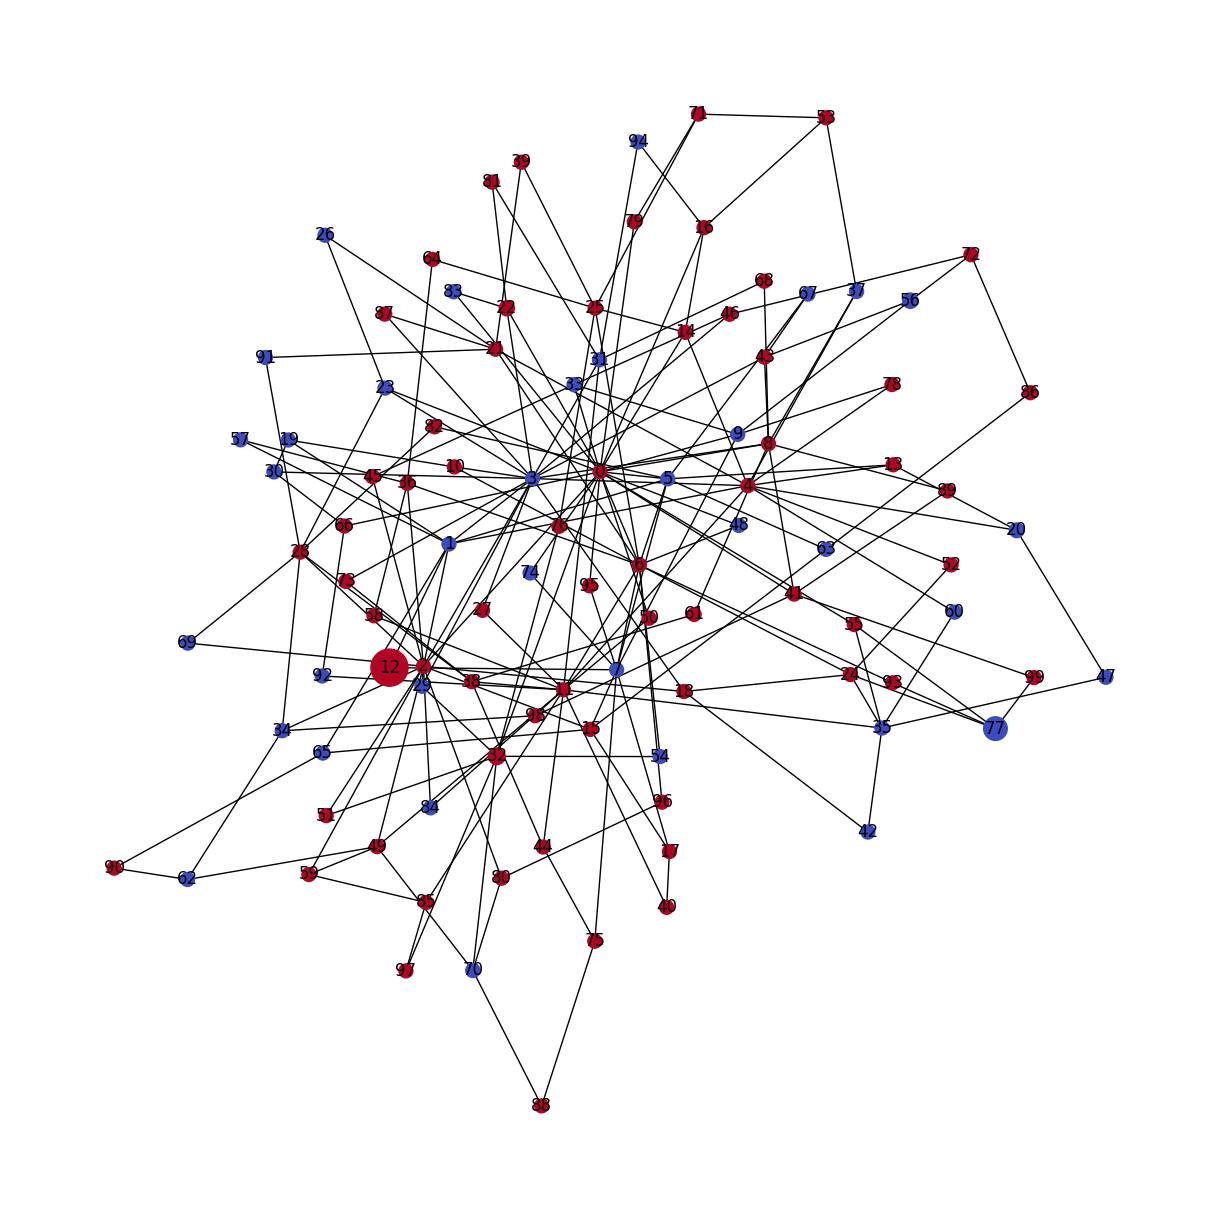

In [8]:
# Define the sigmoidal function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Run the simulation
G, processing_capacity, creation_ability, info_cascade, info_creation_sum = run_simulation(num_nodes=100, min_degree=2, max_degree=20, alpha=2.5, processing_capacity_loc=50, processing_capacity_scale=10, creation_ability_loc=5, creation_ability_scale=1)
# Apply the sigmoidal function to the creation_ability
creation_ability = sigmoid(creation_ability)
# Convert creation_ability to binary
creation_ability_binary = np.where(creation_ability >= 0.99, 1, 0)

# Get processing capacity values from the graph nodes
processing_capacity_values = [processing_capacity[i] for i in G.nodes()]
# Apply softmax to the processing capacity values
softmax_values = np.exp(processing_capacity_values) / np.sum(np.exp(processing_capacity_values))
# Scale the softmax values to be between 10 and 100
scaled_values = np.interp(softmax_values, (0, 1), (100, 1000))
# Set the node sizes to be the scaled softmax values
node_sizes = list(scaled_values)

# Draw the graph with node sizes based on processing capacity and node colors based on binary creation ability
# node_sizes = [processing_capacity[i]*processing_capacity[i]/10 for i in G.nodes()]
node_colors = creation_ability_binary
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42) #  applies the Fruchterman-Reingold force-directed algorithm to find positions for the nodes in a graph
nx.draw(G, pos, node_size=node_sizes, node_color=node_colors, cmap='coolwarm')
nx.draw_networkx_labels(G, pos)
# Show the plot
plt.show()